## Introdução


Este projeto baseia-se, em parte, no material e nas referências fornecidas pelo artigo “Flavours of Physics: the machine learning challenge for the search of τ− → µ−µ−µ+ decays at LHCb”, utilizado como exemplo.


A física de partículas busca descobrir os componentes mais básicos da matéria e as maneiras como interagem. A teoria do Modelo Padrão descreve com sucesso essas relações e prevê a existência de todas as partículas elementares, que já foram detectadas experimentalmente. No entanto, existem diversos conceitos que o Modelo Padrão não consegue explicar completamente, como a matéria escura e, principalmente, a assimetria matéria-antimatéria.

A busca por uma nova física, que explique esses fenômenos, pode ser realizada através da identificação de eventos que violem o previston pelo modelo padrão, como violação do sabor leptônico. A observação de violações, como no decaimento τ−→µ−μ−μ+, representaria uma evidência de nova física, além do Modelo Padrão, e nos ajudaria a compreender novas perspectivas das leis da natureza.


### Desafio


Esse trabalho é fruto de um desafio do CERN que ocorreu em 2015 no Kaggle, proposta pelo proprio CERN, em específico o experimento do LHCb.


O principal objetivo deste desafio é aumentar a sensibilidade na busca por decaimentos τ− →µ−µ−µ+. Isso é alcançado ao aprimorar o poder de discriminação entre eventos de sinal (onde o decaimento ocorreu) e eventos de ruído (onde não ocorreu). Foram fornecidas amostras de sinal e ruído para treinamento e teste. A avaliação é realizada em duas etapas: primeiramente, verifica-se se o classificador não depende fortemente das discrepâncias entre dados reais e simulação e se não está muito correlacionado com a massa do τ. A segunda etapa consiste na avaliação do classificador usando a área sob a curva ROC ponderada.


A equipe vencedora recebeu um prêmio em dinheiro e um convite para visitar o LHCb. Para concorrer, além de apresentar um bom desempenho nos testes e resultados satisfatórios, o código deveria atender aos seguintes critérios:

- Ser uma solução simples e original
- Não possuir um custo computacional muito alto
- Viabilidade de aplicação em ambiente de produção
- Robustez frente à limitação de dados de treinamento


### Objetivo do trabalho

Desenvolver um modelo probabilístico de machine learning para identificar eventos raros de decaimento do tau em três múons, utilizando dados reais e simulados do detector LHCb.


## Bibliotecas


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Markdown
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [2]:
%load_ext autoreload
%autoreload 2

### Functions


In [3]:
from functions import (
    plot_importance_xgb,
    plot_importance_rf,
    metrics_markdown,
    plot_roc_curve,
    plot_mass_corr,
)

## Import Data


In [4]:
train = pd.read_csv("data/training.csv")
test = pd.read_csv("data/test.csv")

check_agreement = pd.read_csv("data/check_agreement.csv")
check_correlation = pd.read_csv("data/check_correlation.csv")

## Exploratory Data Analysis (EDA)


### training.csv


In [5]:
# Conjunto de dados de treinamento, contendo 51 atributos

| Auxiliares    | Descrição                                   |
| ------------- | ------------------------------------------- |
| `production`  | Fonte de produção do tau                    |
| `id`          | Identificador único do evento               |
| `signal`      | Indica se o evento é sinal (1) ou ruído (0) |
| `min_ANNmuon` | Rede neural que identifica múons            |


| Dados do Tau     | Descrição                                                                                           |
| ---------------- | --------------------------------------------------------------------------------------------------- |
| `LifeTime`       | Tempo de vida do candidato a tau                                                                    |
| `dira`           | Cosseno do ângulo entre o momento do tau e a linha entre o vértice primário (PV) e o vértice do tau |
| `pt`             | Momento transverso do tau                                                                           |
| `FlightDistance` | Distância entre o tau e o vértice primário (PV - ponto de colisão dos prótons originais)            |
| `VertexChi2`     | $\chi^2$ do vértice do tau                                                                          |
| `IP`             | Parâmetro de impacto do candidato a tau                                                             |
| `IPSig`          | Significância do parâmetro de impacto                                                               |
| `mass`           | Massa invariante do candidato a tau                                                                 |


| Dados dos Múons    | Descrição                                     |
| ------------------ | --------------------------------------------- |
| `p0_pt`            | Momento transverso do múon p0                 |
| `p1_pt`            | Momento transverso do múon p1                 |
| `p2_pt`            | Momento transverso do múon p2                 |
| `p0_p`             | Momento do múon p0                            |
| `p1_p`             | Momento do múon p1                            |
| `p2_p`             | Momento do múon p2                            |
| `p0_eta`           | Pseudorapidez do múon p0                      |
| `p1_eta`           | Pseudorapidez do múon p1                      |
| `p2_eta`           | Pseudorapidez do múon p2                      |
| `DOCAone`          | Distância de aproximação máxima entre p0 e p1 |
| `DOCAtwo`          | Distância de aproximação máxima entre p1 e p2 |
| `DOCAthree`        | Distância de aproximação máxima entre p0 e p2 |
| `iso`              | Variável de isolamento de trilha              |
| `isolationa`       | Variável de isolamento de trilha              |
| `isolationb`       | Variável de isolamento de trilha              |
| `isolationc`       | Variável de isolamento de trilha              |
| `isolationd`       | Variável de isolamento de trilha              |
| `isolatione`       | Variável de isolamento de trilha              |
| `isolationf`       | Variável de isolamento de trilha              |
| `ISO_SumBDT`       | Variável de isolamento de trilha              |
| `p0_IsoBDT`        | Variável de isolamento de trilha              |
| `p1_IsoBDT`        | Variável de isolamento de trilha              |
| `p2_IsoBDT`        | Variável de isolamento de trilha              |
| `p0_track_Chi2Dof` | Qualidade da trilha do múon p0                |
| `p1_track_Chi2Dof` | Qualidade da trilha do múon p1                |
| `p2_track_Chi2Dof` | Qualidade da trilha do múon p2                |
| `CDF1`             | Variável de isolamento de cone                |
| `CDF2`             | Variável de isolamento de cone                |
| `CDF3`             | Variável de isolamento de cone                |


In [6]:
train.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,0.083660,0.208855,0.074343,8,5,7,1.0,0.0,3.0,4.0,0.473952,0.349447,0.329157,-0.579324,-0.256309,-0.215444,-0.107570,1.921700,0.866657,1.230708,0.988054,0.601483,0.277090,16.243183,4.580875,5.939936,353.819733,448.369446,1393.246826,3842.096436,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,0.030784,0.336345,0.173161,7,12,2,0.0,1.0,1.0,2.0,0.325785,0.265939,0.192599,-0.873926,-0.223774,-0.224871,-0.425281,0.958776,0.858357,1.810709,0.098752,0.219099,0.614524,3.610463,15.555593,11.238523,656.524902,2033.918701,747.137024,8299.368164,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,0.096829,0.169165,0.079789,1,0,1,0.0,0.0,0.0,0.0,1.000000,0.786482,0.557760,-0.479636,-0.202451,-0.100762,-0.176424,0.720973,1.408519,1.038347,0.186143,0.215668,0.371820,4.851371,11.590331,13.723293,658.523743,2576.380615,963.652466,11323.134766,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,0.044816,0.050989,0.068167,2,2,4,0.0,0.0,0.0,0.0,1.000000,0.501195,0.501195,-0.439453,-0.162267,-0.176424,-0.100762,1.172767,2.044164,0.811454,0.255752,0.210698,0.392195,7.292110,8.778173,16.462036,1047.216187,1351.734131,1685.003662,11502.081055,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,0.019026,0.172065,0.131732,0,2,0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.639926,-0.822285,-0.291524,-0.261078,-0.269682,1.523252,0.435325,0.581312,0.270755,0.183355,0.630763,6.783962,3.342091,17.252840,1442.538208,1755.792236,1282.428711,74117.117188,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67553 entries, 0 to 67552
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   67553 non-null  int64  
 1   LifeTime             67553 non-null  float64
 2   dira                 67553 non-null  float64
 3   FlightDistance       67553 non-null  float64
 4   FlightDistanceError  67553 non-null  float64
 5   IP                   67553 non-null  float64
 6   IPSig                67553 non-null  float64
 7   VertexChi2           67553 non-null  float64
 8   pt                   67553 non-null  float64
 9   DOCAone              67553 non-null  float64
 10  DOCAtwo              67553 non-null  float64
 11  DOCAthree            67553 non-null  float64
 12  IP_p0p2              67553 non-null  float64
 13  IP_p1p2              67553 non-null  float64
 14  isolationa           67553 non-null  int64  
 15  isolationb           67553 non-null 

##### Production


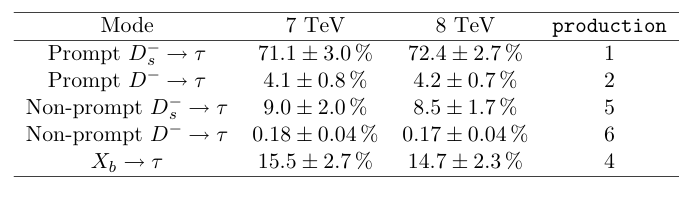


Production mechanisms and their proportions for tau leptonsat LHCb, according the centre-of-mass energy.Xb denotes any particle containing a beauty(b)quark.

productionisa label that, in the simulation, specifies the production mechanism of τ. In data, this label is set to-99.


In [8]:
train["production"].unique()

array([-99,   1,   4,   8,   9,   5,   2,   6,   3,   7,  10])

In [9]:
np.sort(train["production"].unique())

array([-99,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10])

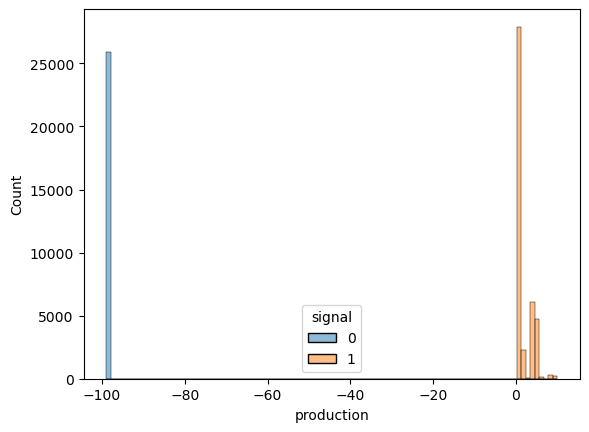

In [10]:
sns.histplot(train, x="production", bins=100, hue="signal")
plt.show()

##### Mass


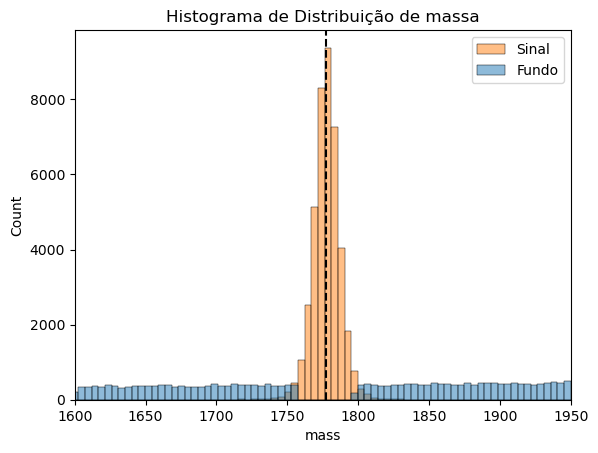

In [11]:
sns.histplot(train, x="mass", bins=100, hue="signal")
plt.legend(labels=["Sinal", "Fundo"], loc="upper right")
plt.title("Histograma de Distribuição de massa")
plt.axvline(1777, color="black", linestyle="--")

plt.xlim(1600, 1950)

plt.show()

É possível observar que a massa é uma característica essencial para o modelo separar o sinal do ruído.


##### min_ANNmuon


Muon identification. LHCb collaboration trains Artificial Neural Networks (ANN) from informations from RICH, ECAL, HCAL, Muon system to distinguish muons from other particles. This variables denotes the minimum of the three muons ANN. **min ANNmuon should not be used for training**. This variable is absent in the test samples


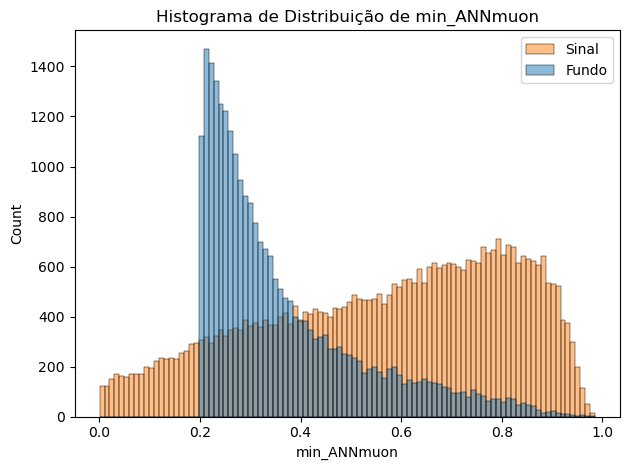

In [12]:
sns.histplot(train, x="min_ANNmuon", bins=100, hue="signal")
plt.legend(labels=["Sinal", "Fundo"], loc="upper right")
plt.title("Histograma de Distribuição de min_ANNmuon")
plt.tight_layout()


plt.show()

The calculation of the final figure of merit is performed only if the two above tests are passed on test.csv with success and is calculated only using events with min ANNmuon> 0.4.


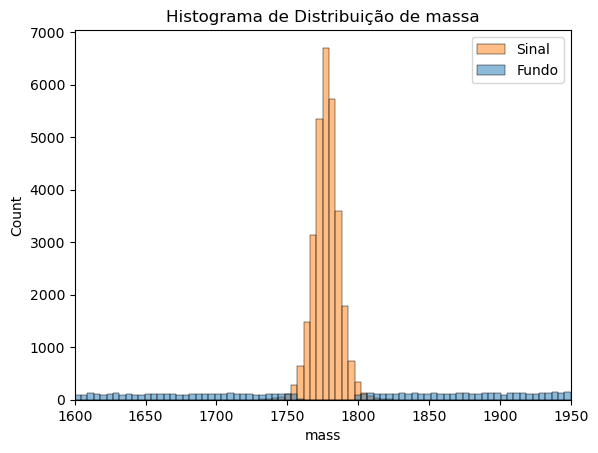

In [13]:
cond_muon = train["min_ANNmuon"] > 0.4
sns.histplot(train[cond_muon], x="mass", bins=100, hue="signal")
plt.legend(labels=["Sinal", "Fundo"], loc="upper right")
plt.title("Histograma de Distribuição de massa")

plt.xlim(1600, 1950)
plt.show()

#### features


In [14]:
features = [
    # Tau parameters
    "LifeTime",  # Life time of tau candidate.
    "dira",  # Cosine of the angle between the τ momentum and line between PV and tau vertex.
    "pt",  # Transverse momentum of τ
    "FlightDistance",  # Distance between τ and primary vertex (PV)
    "FlightDistanceError",
    "VertexChi2",
    "IP",  # Impact Parameter of tau candidate.
    "IPSig",  # Significance of Impact Parameter
    "mass",
    # Muons parameters
    ## Impact
    "p0_IP",
    "p1_IP",
    "p2_IP",
    "p0_IPSig",
    "p1_IPSig",
    "p2_IPSig",
    "IP_p0p2",  # Impact parameter of the p0 and p2 pair.
    "IP_p1p2",
    ## Kinematics
    "p0_pt",  # Transverse momentum
    "p1_pt",
    "p2_pt",
    "p0_p",  # Momentum
    "p1_p",
    "p2_p",
    "p0_eta",  # Pseudorapidity
    "p1_eta",
    "p2_eta",
    "DOCAone",  # Distance of Closest Approach between p0 and p1
    "DOCAtwo",
    "DOCAthree",
    # "SPDhits",  # Hits in the SPD (Spin Physics Detector)
    ## Track
    "iso",  # Track isolation variable.
    "isolationa",
    "isolationb",
    "isolationc",
    "isolationd",
    "isolatione",
    "isolationf",
    "ISO_SumBDT",
    "p0_IsoBDT",
    "p1_IsoBDT",
    "p2_IsoBDT",
    "p0_track_Chi2Dof",  #  Quality of p0 muon track.
    "p1_track_Chi2Dof",
    "p2_track_Chi2Dof",
    ## Cone
    "CDF1",  # Cone isolation variable
    "CDF2",
    "CDF3",
]

features_without_mass = [feature for feature in features if "mass" not in feature]

aux_features = [
    "production",
    "signal",
    "id",
    "min_ANNmuon",
]

In [15]:
len(features)

46

### test.csv


É um conjunto de dados não rotulado (sinal e ruído estão misturados e indistinguíveis para os participantes), contendo eventos de sinal simulados e dados reais de ruído, eventos simulados e dados reais para o canal de controle


Features faltando:

- signal
- mass
- min_ANNmuon
- production


In [16]:
test.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
0,14711831,0.001273,0.999816,8.569642,0.310039,0.197893,5.183939,2.286117,687.479248,0.022301,0.050763,0.124735,0.148945,0.065997,0,1,4,2.0,2.0,0.0,4.0,0.448872,0.411983,0.141371,-0.751272,-0.145808,-0.280569,-0.324895,0.753610,1.846906,1.031751,0.329494,0.872634,0.686377,3.465280,10.841214,22.478136,508.926514,306.629456,714.222717,30300.734375,5662.158691,7406.368164,4.779700,3.608334,3.029715,705
1,16316387,0.000661,0.999954,7.061379,0.348772,0.067430,6.316281,3.865824,5691.845703,0.002455,0.037633,0.005614,0.116943,0.117106,19,6,9,3.0,0.0,3.0,6.0,0.389287,0.187060,0.076054,-0.347637,-0.115879,-0.115879,-0.115879,2.076739,1.069274,1.009442,0.457204,0.150543,0.165927,13.728366,10.874161,8.310439,943.130676,3287.291260,1563.593994,6160.323730,43781.566406,19728.500000,2.563915,3.280884,3.226650,907
2,6771382,0.000889,0.999999,6.502967,0.273914,0.011020,0.865816,1.004631,5429.225586,0.002753,0.036379,0.040004,0.110153,0.183199,0,3,1,0.0,0.0,0.0,0.0,1.000000,0.960757,0.960757,-0.777667,-0.222446,-0.222446,-0.332776,1.194183,0.710145,1.094024,0.162487,0.199006,0.564369,9.725705,13.215377,11.707615,2886.055908,2216.936279,598.068359,26387.134766,15534.978516,6504.145020,2.903129,2.634985,3.077517,213
3,686045,0.001295,0.999301,7.838184,0.325697,0.388636,11.391245,10.345356,661.717834,0.008163,0.436003,0.188972,0.458021,0.551724,9,5,1,2.0,0.0,1.0,3.0,0.352854,0.143209,0.137221,-0.482896,-0.084681,-0.100762,-0.297453,1.512858,1.091243,1.011030,0.656599,0.304019,0.801548,17.860973,3.498727,16.569244,461.727753,357.967560,1118.084229,5451.857422,10281.403320,23722.742188,3.160085,4.050494,3.747409,275
4,8755882,0.001714,0.999805,7.064559,0.113440,0.154421,13.925871,12.951378,3885.417969,0.066317,0.052183,0.029873,0.376774,0.412828,13,6,6,0.0,2.0,1.0,3.0,0.313903,0.250328,0.240195,-0.451658,-0.115879,-0.183488,-0.152291,1.555909,1.221972,1.544137,0.546148,0.417822,0.828005,44.483707,24.498425,20.247360,1773.747925,1643.278198,711.572205,7724.954590,12830.546875,6008.145996,2.151059,2.744157,2.823017,357


In [17]:
test.shape[1]

47

### check_agreement.csv


**Objetivo:** Garantir que o classificador não tenha grandes discrepâncias ao ser aplicado a dados e a simulações.

Aplica o teste Kolmogorov-Smirnov (KS), usado para avaliar as diferenças entre funções de distribuição cumulativa do classificador no dado simulado (Monte Carlo) e o real.


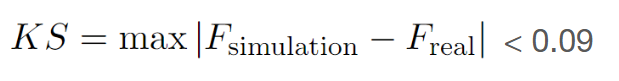


Features faltando:

- production
- mass
- min_ANNmuon


In [18]:
check_agreement.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,signal,weight
0,15347063,0.001451,0.999964,6.945030,0.229196,0.058117,2.961298,7.953543,2251.611816,0.082219,0.084005,0.066887,0.185107,0.214719,8,6,1,2.0,1.0,1.0,4.0,0.732076,0.492269,0.179091,-0.207475,-0.019306,-0.089797,-0.098372,0.606178,0.862549,1.487057,0.483199,0.474925,0.426797,24.701061,10.732132,8.853514,1438.064697,468.645721,834.562378,10392.814453,6380.673828,15195.594727,2.666142,3.302978,3.594246,512,0,-0.307813
1,14383299,0.000679,0.999818,9.468235,0.517488,0.189683,14.413060,7.141451,10594.470703,0.007983,0.044154,0.001321,0.039357,0.217507,5,6,17,1.0,1.0,1.0,3.0,0.802508,0.605835,0.584701,-0.659644,-0.278330,-0.186370,-0.194944,1.900118,1.073474,1.336784,0.712242,0.260311,0.123877,11.312134,16.435398,7.737038,316.791351,7547.703613,2861.309814,3174.356934,64480.023438,23134.953125,2.995265,2.834816,2.779366,552,0,-0.331421
2,7382797,0.003027,0.999847,13.280714,0.219291,0.231709,11.973175,4.778880,2502.196289,0.045085,0.106614,0.005850,0.335788,0.885080,2,2,1,0.0,0.0,1.0,1.0,0.682607,0.682607,0.295038,-0.399239,-0.115879,-0.131069,-0.152291,0.660675,1.683084,0.798658,0.381544,1.163556,1.290409,16.435801,20.686119,44.521961,1887.477905,317.579529,932.128235,15219.761719,3921.181641,10180.791016,2.776633,3.204923,3.081832,318,0,-0.382215
3,6751065,0.000810,0.999998,5.166821,0.167886,0.011298,0.891142,5.528002,5097.813965,0.055115,0.038642,0.003864,0.076522,0.068347,4,4,3,0.0,0.0,0.0,0.0,0.533615,0.533615,0.533615,-0.821041,-0.208248,-0.177802,-0.434991,0.770563,1.093031,0.938619,0.564650,0.164411,0.166646,24.878387,7.873435,9.630725,975.041687,1650.837524,2617.248291,4365.082520,13221.149414,24291.875000,2.179345,2.769762,2.918251,290,0,1.465194
4,9439580,0.000706,0.999896,10.897236,0.284975,0.160511,16.367550,8.670339,20388.097656,0.015587,0.020872,0.014612,0.249906,0.139937,0,1,0,0.0,0.0,0.0,0.0,0.926410,0.926410,0.926410,-1.116815,-0.328938,-0.443564,-0.344313,1.080559,1.471946,1.123868,0.373736,0.230584,0.112430,28.557213,18.738485,7.389726,6035.000977,9657.492188,4763.682617,27463.011719,46903.394531,24241.628906,2.196114,2.262732,2.310401,45,0,-0.477084


In [19]:
check_agreement.shape[1]

49

### check_correlation.csv


**Objetivo:** Garantir que o classificador esteja descorrelacionado da massa (τ), pois isso pode levar a falsas estimações.

Aplica o teste Cramer-von Mises (CvM), verificando a correlação entre as previsões do modelo e a massa das partículas comparando as distribuições cumulativas das previsões em diferentes intervalos de massa.


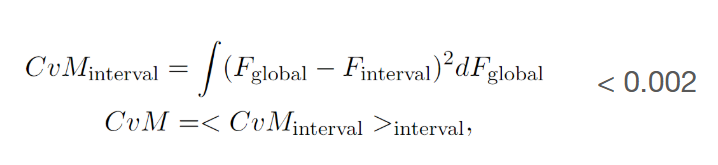


Features faltando:

- signal
- production
- min_ANNmuon


In [20]:
check_correlation.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,mass
0,11120335,0.000703,0.999715,2.927074,0.214014,0.081302,4.259793,1.066585,3108.189941,0.010767,0.024147,0.003066,0.100619,0.087596,2,10,5,2.0,1.0,1.0,4.0,0.661286,0.592280,0.592280,-0.229346,-0.089797,-0.049752,-0.089797,1.015762,0.918588,2.555963,0.336053,0.138520,0.239775,6.975648,7.199831,9.638602,1142.124512,1294.450928,1073.976440,9274.671875,7963.914062,6712.897949,2.783731,2.503310,2.519349,280,1723.887939
1,11495369,0.000601,0.999950,15.849142,0.842973,0.182213,13.882857,5.780046,6858.264648,0.007574,0.020010,0.064194,0.058354,0.247012,3,3,4,0.0,1.0,1.0,2.0,0.744360,0.441476,0.209664,-0.364786,-0.115879,-0.124454,-0.124454,1.413934,0.696266,1.531379,0.282444,0.298322,0.168395,10.620588,17.345636,7.344349,1174.860229,3981.284912,1859.680542,22844.791016,109955.101562,37051.800781,3.660059,4.011287,3.684429,386,1926.284058
2,7098902,0.002009,0.999984,43.358494,1.323199,0.200158,12.870687,3.460782,3604.347412,0.052849,0.127547,0.073476,0.365799,0.292673,0,1,0,0.0,0.0,0.0,0.0,0.699672,0.678214,0.437321,-1.175178,-0.351104,-0.414748,-0.409326,1.307686,1.081815,0.674668,0.173122,0.480514,1.041596,4.409735,30.871080,7.409998,1046.867310,2564.430420,354.095032,45214.070312,77265.429688,12087.007812,4.458619,4.098382,4.223254,433,1830.873047
3,8103692,0.001268,0.999550,6.910733,0.198652,0.167730,8.559438,7.676139,3240.960449,0.101368,0.002148,0.037449,0.060147,0.162985,4,9,4,1.0,1.0,1.0,3.0,0.257655,0.184313,0.182857,-0.495822,-0.194944,-0.176424,-0.124454,1.019122,2.248540,1.243463,0.390963,0.627191,0.136959,11.687304,31.343948,4.312659,1051.328979,1178.332031,1285.701660,11245.551758,6770.969238,17003.119141,3.060873,2.434033,3.273807,245,1909.119019
4,10160864,0.001937,0.999996,36.135208,0.508036,0.097170,9.295684,0.426340,6448.445312,0.007005,0.008510,0.009841,0.481759,0.455559,0,4,0,0.0,0.0,0.0,0.0,0.588020,0.537217,0.222616,-0.766796,-0.263475,-0.263475,-0.239847,0.766173,0.715839,0.847636,0.612008,0.498065,0.641609,38.172073,38.144756,14.099512,3081.089111,3140.512207,385.343475,48171.457031,43973.835938,7368.522949,3.441606,3.331079,3.643300,489,1600.925049


In [21]:
check_correlation.shape[1]

48

### Preprocessing


#### Feature Engineering


##### Mass reconstruction


In LHCb, the z axis is choosen to be the direction of the beam, as shown with red arrows


- Kinematic relations


Podemos calcular o momento longitudinal ($p_z$) usando o momento transverso ($p_T$) e a pseudorapidez ($\eta$) ou usando o momento total ($p$).


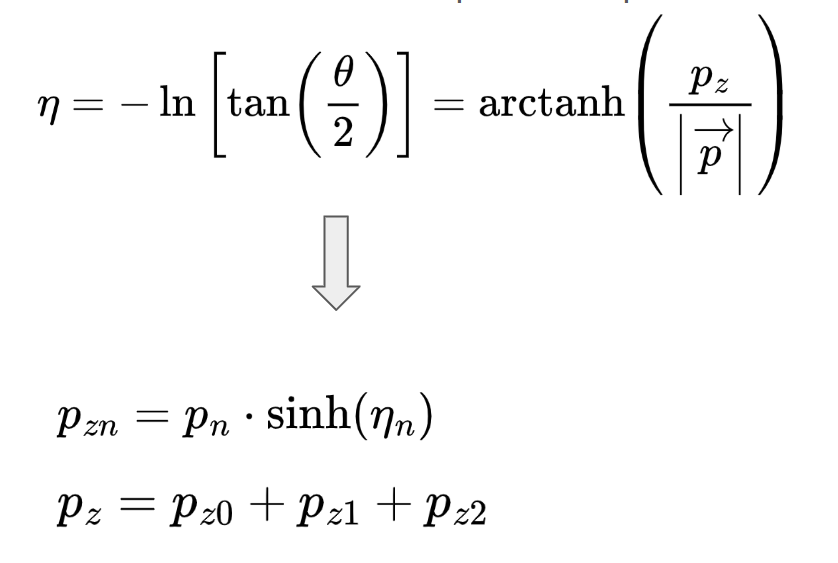


In [22]:
def calc_pz(df, method="momentum"):
    if method == "momentum":
        p0_z = np.sqrt(np.square(df["p0_p"]) - np.square(df["p0_pt"]))
        p1_z = np.sqrt(np.square(df["p1_p"]) - np.square(df["p1_pt"]))
        p2_z = np.sqrt(np.square(df["p2_p"]) - np.square(df["p2_pt"]))
    elif method == "pseudorapidity":
        p0_z = df["p0_pt"] * np.sinh(df["p0_eta"])
        p1_z = df["p1_pt"] * np.sinh(df["p1_eta"])
        p2_z = df["p2_pt"] * np.sinh(df["p2_eta"])
    pz = p0_z + p1_z + p2_z
    return pz

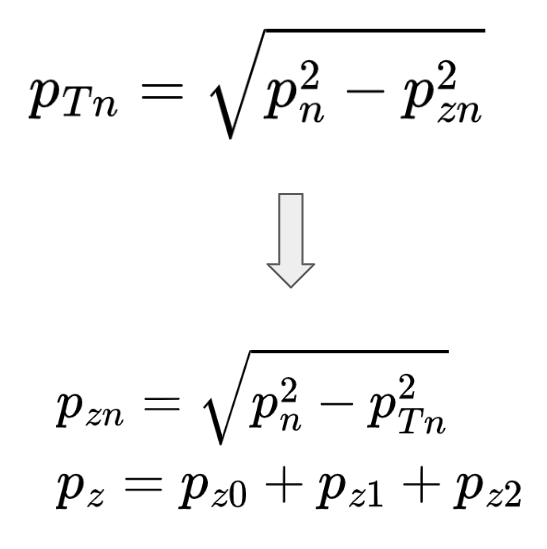


In [23]:
def calc_p(df):
    p = np.sqrt(np.square(df["pt"]) + np.square(calc_pz(df)))
    return p

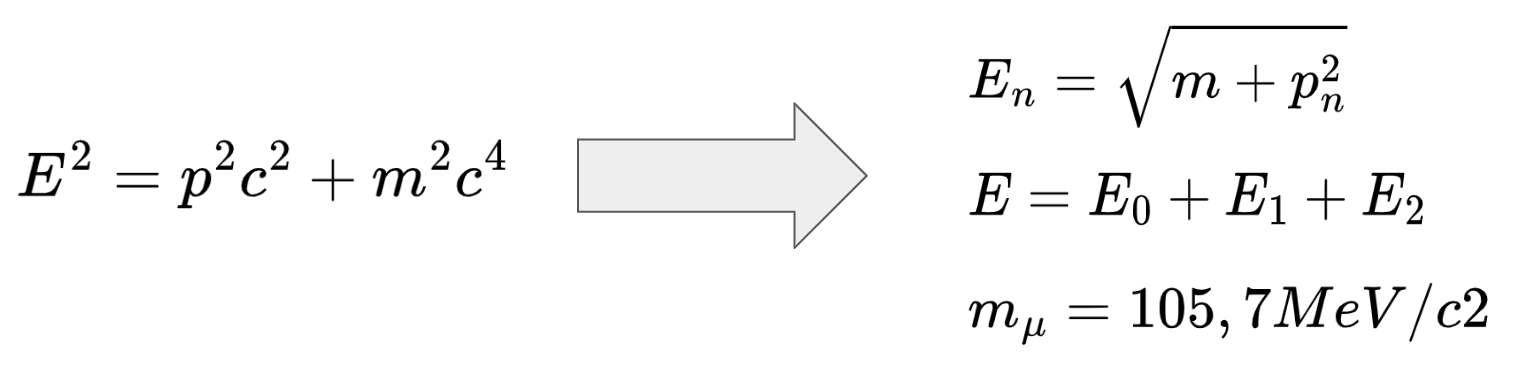


In [24]:
def calc_e(df):
    MUON_MASS = 105.66  # MeV
    e0 = np.sqrt(np.square(MUON_MASS) + np.square(df["p0_p"]))
    e1 = np.sqrt(np.square(MUON_MASS) + np.square(df["p1_p"]))
    e2 = np.sqrt(np.square(MUON_MASS) + np.square(df["p2_p"]))
    e = e0 + e1 + e2
    return e

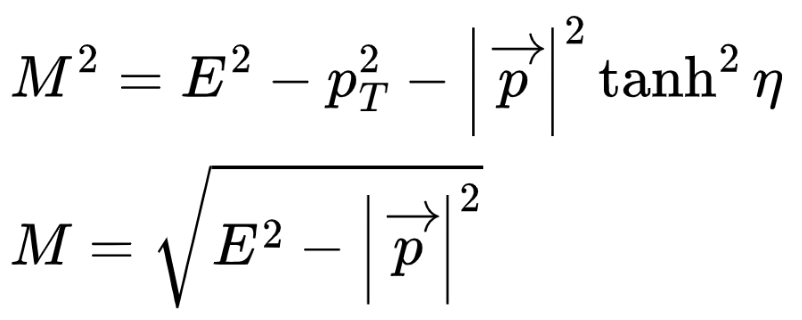


In [25]:
def calc_mass(df):
    e = calc_e(df)
    p = calc_p(df)
    mass = np.sqrt(np.square(e) - np.square(p))
    return mass

- Mass estimation analysis


In [26]:
mass = calc_mass(train)

c:\Users\jonh\AppData\Local\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


A massa do tau é de aproximadamente 1777.68 MeV.


In [27]:
print(f"Valor médio da massa do Tau {mass.mean():.3f} GeV nos dados de treino.")
print(f"O desvio padrão foi de {mass.std():.3f} GeV nos dados de treino.")

Valor médio da massa do Tau 1779.843 GeV nos dados de treino.
O desvio padrão foi de 77.369 GeV nos dados de treino.


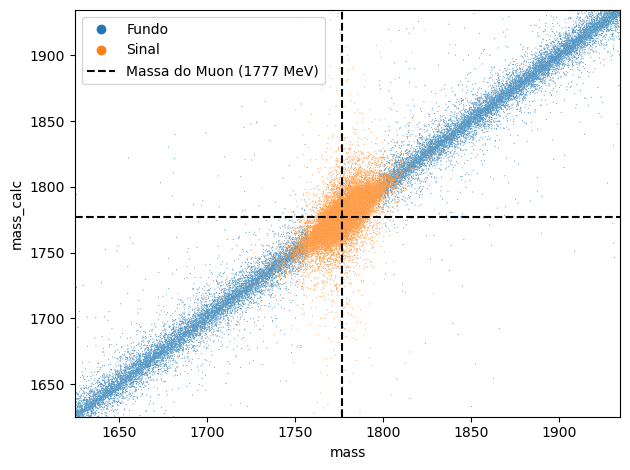

In [28]:
plot_mass_corr(train, mass)

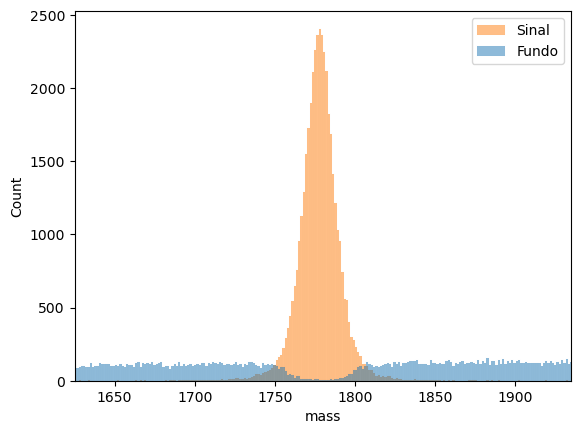

In [29]:
stds = 2
start = mass.mean() - (mass.std() * stds)
end = mass.mean() + (mass.std() * stds)
sns.histplot(data=train, x=mass, hue="signal")



plt.legend(labels=["Sinal", "Fundo"], loc="upper right")


plt.xlabel("mass")


plt.xlim(start, end)


plt.show()

##### Add mass


In [30]:
test["mass"] = calc_mass(test)
check_agreement["mass"] = calc_mass(check_agreement)

c:\Users\jonh\AppData\Local\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jonh\AppData\Local\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
print(
    f'Valor médio da massa do Tau {test["mass"].mean():.3f} GeV nos dados de agreement.'
)
print(f'O desvio padrão foi de {test["mass"].std():.3f} GeV nos dados de agreement.')

Valor médio da massa do Tau 1942.239 GeV nos dados de agreement.
O desvio padrão foi de 70.761 GeV nos dados de agreement.


In [32]:
print(
    f'Valor médio da massa do Tau {check_agreement["mass"].mean():.3f} GeV nos dados de agreement.'
)
print(
    f'O desvio padrão foi de {check_agreement["mass"].std():.3f} GeV nos dados de agreement.'
)

Valor médio da massa do Tau 1959.629 GeV nos dados de agreement.
O desvio padrão foi de 38.873 GeV nos dados de agreement.


#### Data


Conforme indicado no artigo e a partir da análise do histograma de min_ANNmuon, optamos por treinar o modelo apenas com os candidatos mais propensos a serem múons.


In [33]:
X_train = train[features][cond_muon].values  # cond_muon
X_test = test[features].values
X_agre = check_agreement[features].values
X_corr = check_correlation[features].values

Vamos rodar um modelo que não utilizará os dados de massa, para reduzir a correlação do modelo geral com a massa


In [34]:
X_train_wm = train[features_without_mass][cond_muon].values
X_test_wm = test[features_without_mass].values
X_agre_wm = check_agreement[features_without_mass].values
X_corr_wm = check_correlation[features_without_mass].values

In [35]:
y_train = train["signal"][cond_muon].values

#### Scaling


Como também pretendemos utilizar um modelo de rede neural, vamos escalonar os dados.


In [36]:
from tensorflow.keras import layers

In [37]:
normalizer = layers.Normalization()
normalizer.adapt(X_train)

In [38]:
X_train_scaled = normalizer(X_train)
X_test_scaled = normalizer(X_test)
X_agre_scaled = normalizer(X_agre)
X_corr_scaled = normalizer(X_corr)

#### PCA


Considerando a natureza dos dados da Física de Altas Energias, o PCA pode não ser uma técnica indicada. Isso porque seus atributos possuem significado físico direto, o que pode ser distorcido pela redução de dimensionalidade.


In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA()
pca.fit(X_train_scaled)

PCA()

In [41]:
cum_variance = np.cumsum(pca.explained_variance_ratio_)

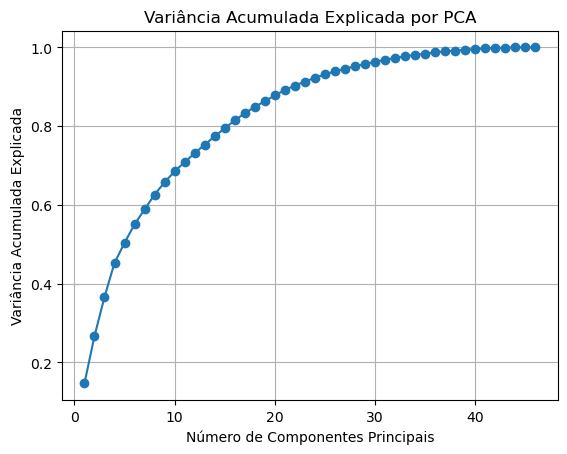

In [42]:
plt.plot(range(1, len(cum_variance) + 1), cum_variance, marker="o")
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Acumulada Explicada")
plt.title("Variância Acumulada Explicada por PCA")
plt.grid(True)
plt.show()

In [43]:
len(cum_variance[cum_variance < 0.91])

22

A variância acumulada atingiu 90% com 22 componentes principais. Notamos também, a ausência de um “cotovelo” acentuado nas primeiras componentes, do gráfico de variância explicada, ideal para a aplicação do PCA. Em função disso, optamos por não utilizar essa técnica.


## Model


### XGB


In [44]:
import xgboost as xgb
from xgboost import plot_tree
from sklearn.model_selection import GridSearchCV

In [45]:
from sklearn.metrics import roc_auc_score
from evaluation import roc_auc_truncated, compute_cvm, check_ks

Foi aplicado um grid search para determinar os valores adequados dos hiperparâmetros. Porém, dado o custo computacional dessa análise, optamos por suprimir essa etapa do código, denxado apenas os valores ótimos.


In [46]:
params = {
    "objective": "binary:logistic",
    "eta": 0.05,
    "max_depth": 50,
    "colsample_bytree": 0.4,
    "eval_metric": "auc",
    "random_state": 23,
}

In [47]:
xgb_model = xgb.train(params, xgb.DMatrix(X_train, y_train))

In [48]:
y_train_hat_xgb = xgb_model.predict(xgb.DMatrix(X_train))
y_agre_hat_xgb = xgb_model.predict(xgb.DMatrix(X_agre))
y_corr_hat_xgb = xgb_model.predict(xgb.DMatrix(X_corr))

In [49]:
from sklearn.metrics import roc_auc_score
from evaluation import roc_auc_truncated, compute_cvm, check_ks

In [50]:
roc_xgb = roc_auc_score(y_true=y_train, y_score=y_train_hat_xgb)
ks_xgb = check_ks(agreement_probs=y_agre_hat_xgb, check_agreement=check_agreement)
cvm_xgb = compute_cvm(predictions=y_corr_hat_xgb, masses=check_correlation["mass"])

In [51]:
metrics_markdown(roc_xgb, ks_xgb, cvm_xgb)


| Metric | Value | Status |
|---|---|---|
| ROC | 0.99995 |   |
| KS  | 0.03581 | ✅ |
| CVM | 0.072174 | ❌ |


ROC alto, com baixo KS e baixo CVM.


In [52]:
feature_names = list(train[features].columns)

In [53]:
xgb_model.feature_names = feature_names

In [54]:
xgb_tree = xgb.to_graphviz(xgb_model, num_trees=0, rankdir="LR")
xgb_tree.view(filename="xgb_tree")

'xgb_tree.pdf'

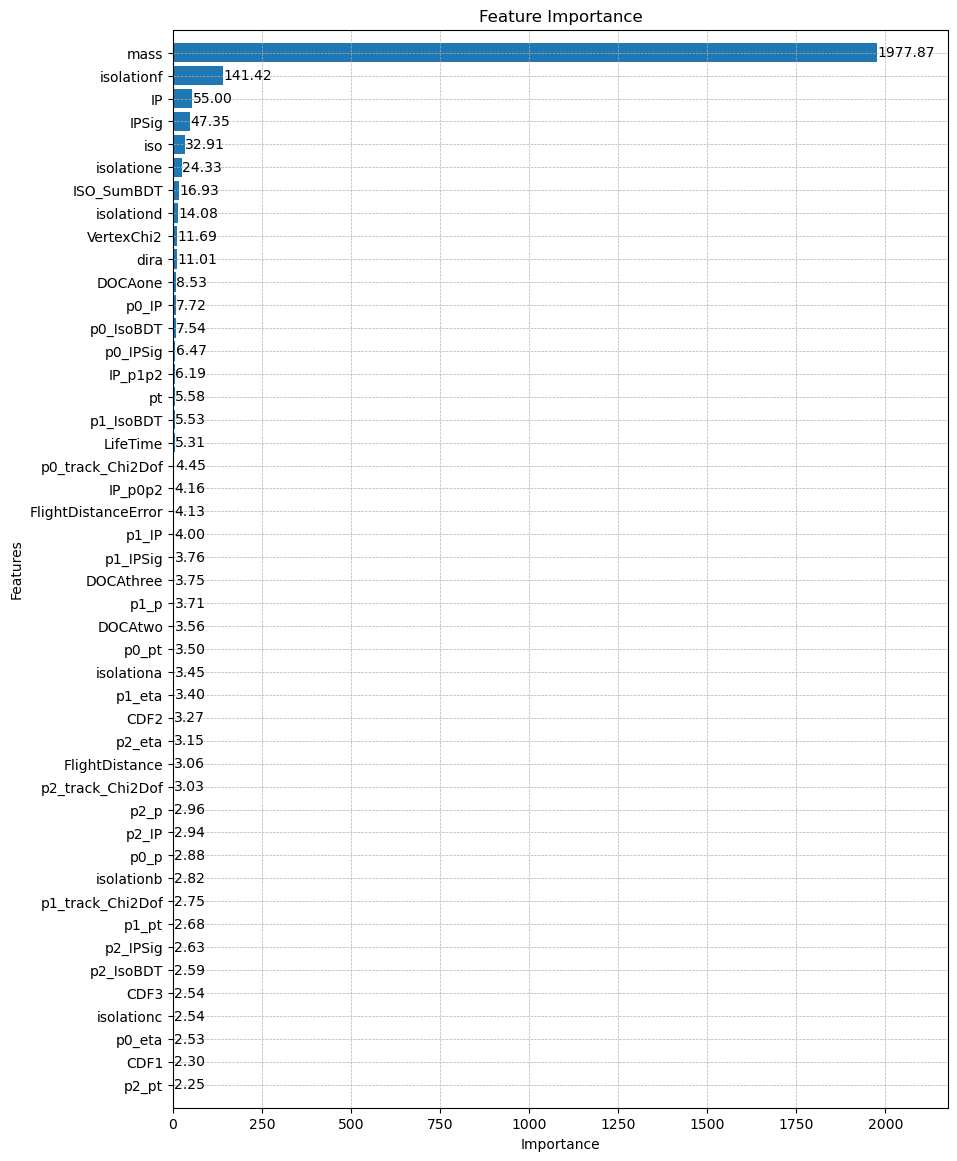

In [55]:
plot_importance_xgb(xgb_model)

### Neural Network


In [56]:
import tensorflow as tf
from tensorflow import keras

Na rede neural, a arquitetura não foi definida por metodologia formal. Inicialmente, testamos com 100 neurônios, o modelo apresentou overfitting e alta correlação com a massa, levando à simplificação da rede.


In [57]:
nn_model = keras.Sequential(
    [
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

nn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [58]:
history = nn_model.fit(
    normalizer(X_train), y_train, epochs=35, verbose=0
)  # 2m39s Approx.

In [59]:
y_train_hat_mlp = np.ravel(nn_model.predict(X_train_scaled))
y_agre_hat_mlp = np.ravel(nn_model.predict(X_agre_scaled))
y_corr_hat_mlp = np.ravel(nn_model.predict(X_corr_scaled))

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10349/10349 ━━━━━━━━━━━━━━━━━━━━ 8s 762us/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


In [60]:
roc_mlp = roc_auc_score(y_true=y_train, y_score=y_train_hat_mlp)
ks_mlp = check_ks(agreement_probs=y_agre_hat_mlp, check_agreement=check_agreement)
cvm_mlp = compute_cvm(
    predictions=np.ravel(y_corr_hat_mlp), masses=check_correlation["mass"]
)

In [61]:
metrics_markdown(roc_mlp, ks_mlp, cvm_mlp)


| Metric | Value | Status |
|---|---|---|
| ROC | 0.99997 |   |
| KS  | 0.46436 | ❌ |
| CVM | 0.11134 | ❌ |


ROC alto, com alto KS e alto CVM.


In [62]:
from functions import plot_nn

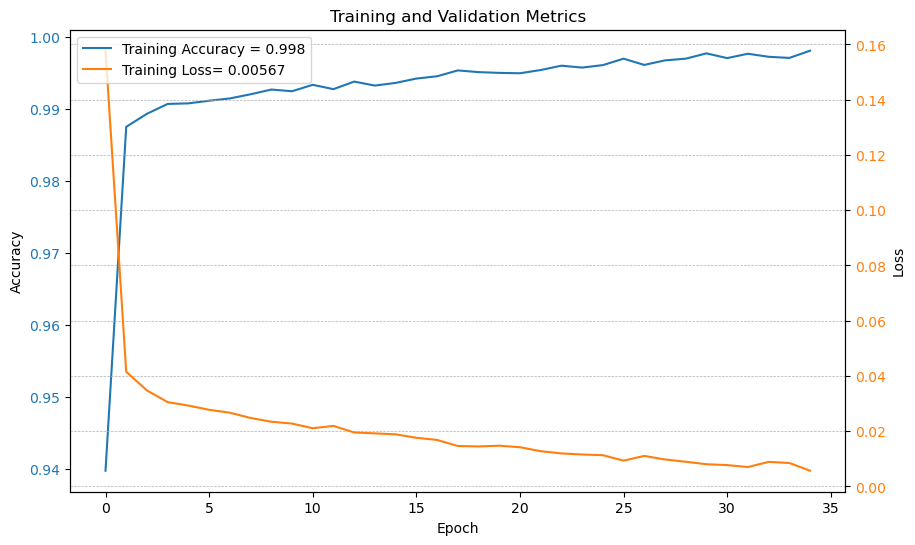

In [63]:
plot_nn(history)

### Random Forest


In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf_model = RandomForestClassifier(
    n_estimators=50, max_depth=10, random_state=42, n_jobs=-1
)

In [66]:
rf_model.fit(X_train_scaled, y_train)

y_train_hat_rf = rf_model.predict(X_train_scaled)
y_agre_hat_rf = rf_model.predict(X_agre_scaled)
y_corr_hat_rf = rf_model.predict(X_corr_scaled)

In [67]:
roc_rf = roc_auc_score(y_true=y_train, y_score=y_train_hat_rf)
ks_rf = check_ks(agreement_probs=y_agre_hat_rf, check_agreement=check_agreement)
cvm_rf = compute_cvm(
    predictions=np.ravel(y_corr_hat_rf), masses=check_correlation["mass"]
)

In [68]:
metrics_markdown(roc_rf, ks_rf, cvm_rf)


| Metric | Value | Status |
|---|---|---|
| ROC | 0.98071 |   |
| KS  | 0.028552 | ✅ |
| CVM | 0.12376 | ❌ |


ROC alto, com KS muito baixo e alto CVM.


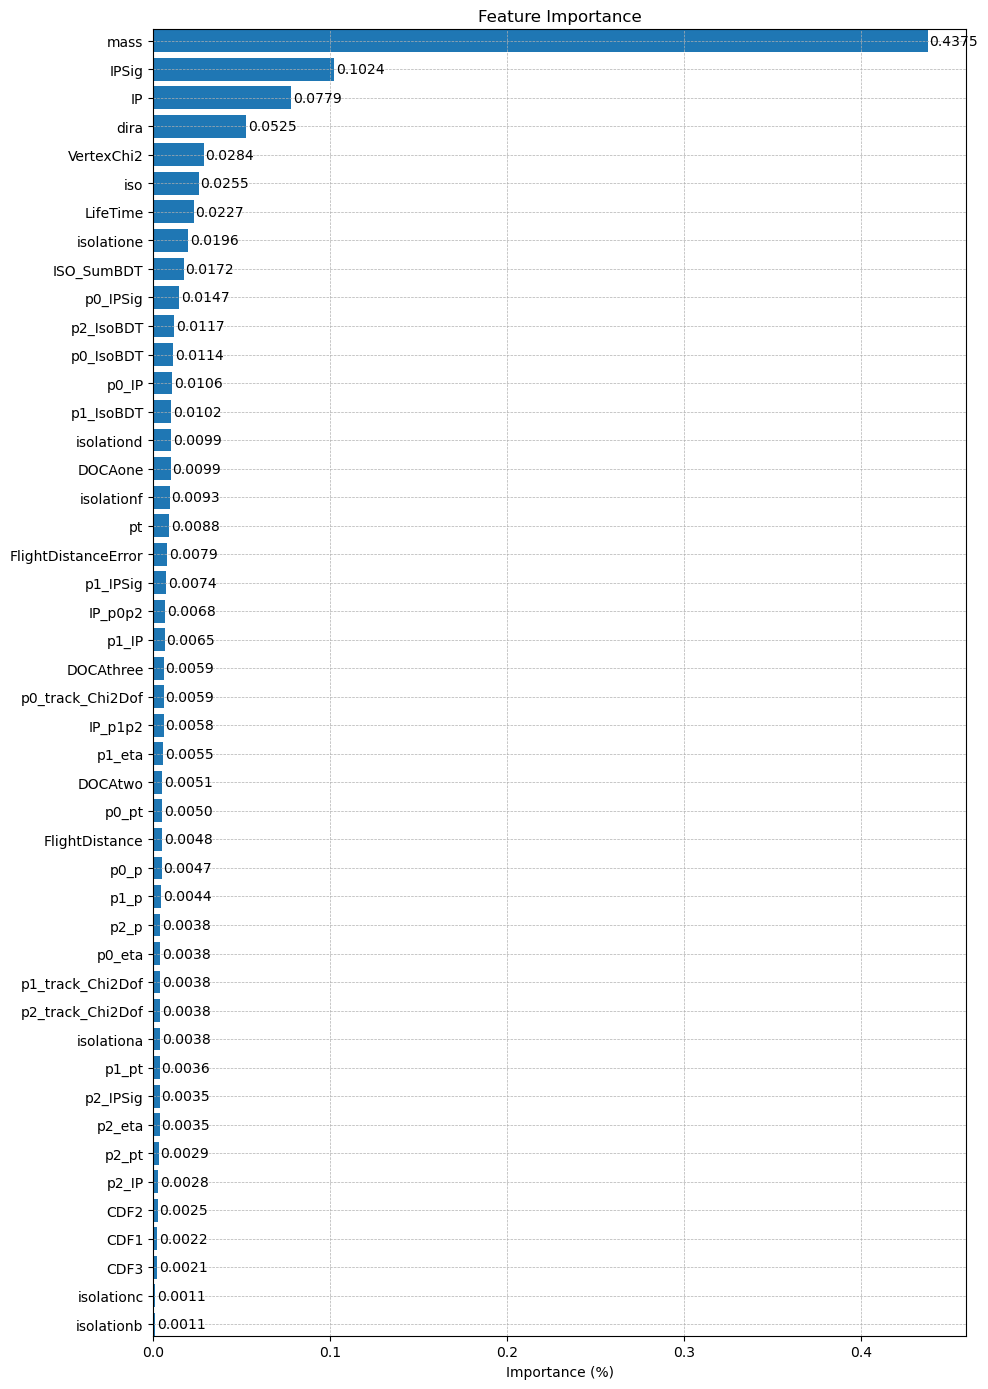

In [69]:
plot_importance_rf(rf_model, feature_names)

### XGM (Sem massa)


In [70]:
params = {
    "objective": "binary:logistic",
    "eta": 0.05,
    "max_depth": 100,
    "colsample_bytree": 0.4,
    "eval_metric": "auc",
    "random_state": 23,
}

In [71]:
xgb_model_wm = xgb.train(
    params,
    xgb.DMatrix(X_train_wm, y_train),
)

In [72]:
y_train_hat_xgb_wm = xgb_model_wm.predict(xgb.DMatrix(X_train_wm))
y_agre_hat_xgb_wm = xgb_model_wm.predict(xgb.DMatrix(X_agre_wm))
y_corr_hat_xgb_wm = xgb_model_wm.predict(xgb.DMatrix(X_corr_wm))

In [73]:
roc_xgb_wm = roc_auc_score(y_true=y_train, y_score=y_train_hat_xgb_wm)
ks_xgb_wm = check_ks(agreement_probs=y_agre_hat_xgb_wm, check_agreement=check_agreement)
cvm_xgb_wm = compute_cvm(
    predictions=y_corr_hat_xgb_wm, masses=check_correlation["mass"]
)

In [74]:
metrics_markdown(roc_xgb_wm, ks_xgb_wm, cvm_xgb_wm)


| Metric | Value | Status |
|---|---|---|
| ROC | 0.99158 |   |
| KS  | 0.034364 | ✅ |
| CVM | 0.00099827 | ✅ |


ROC alto, com baixo KS e CVM extremamente baixo.


In [75]:
feature_names_sm = list(train[features_without_mass].columns)

In [76]:
xgb_model_wm.feature_names = feature_names_sm

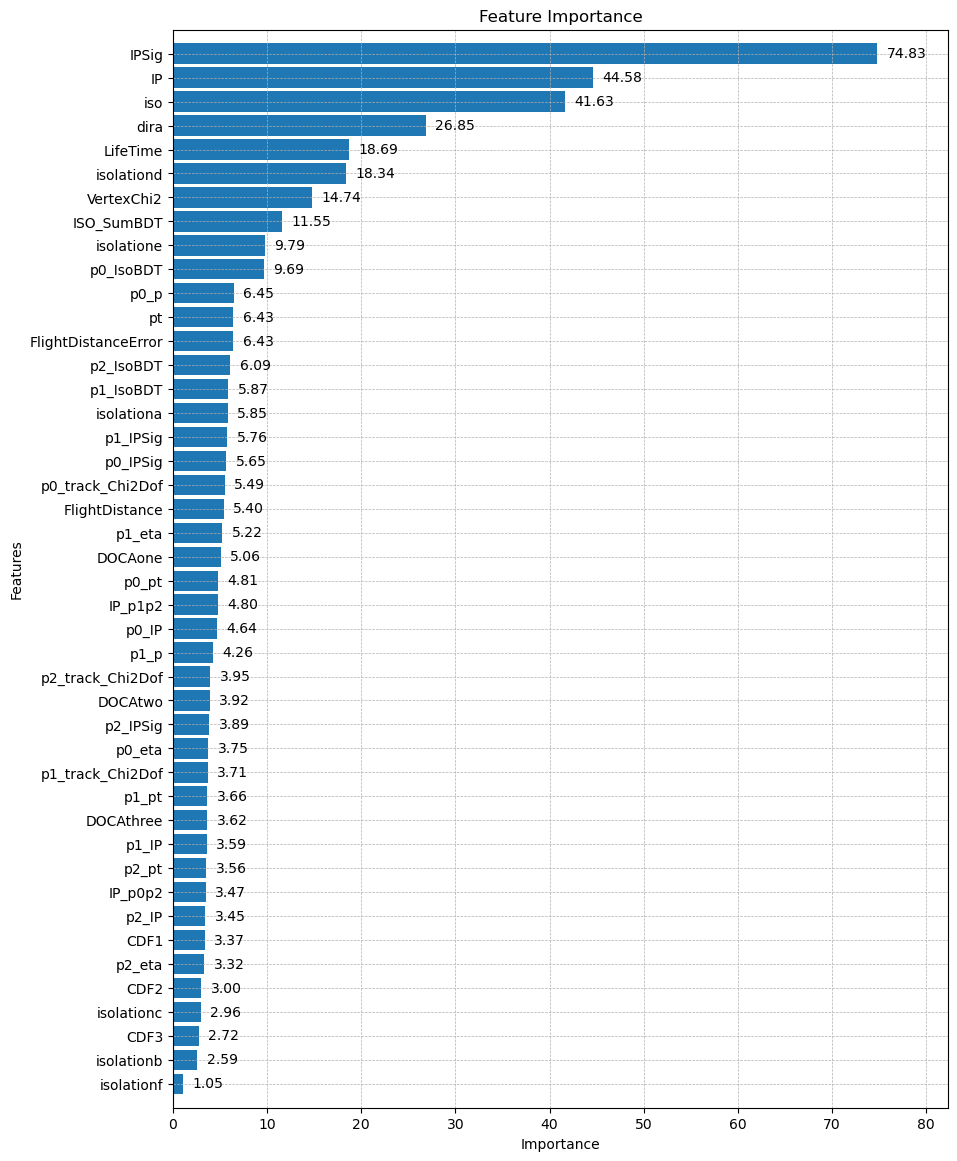

In [77]:
plot_importance_xgb(xgb_model_wm)

### Análise dos modelos


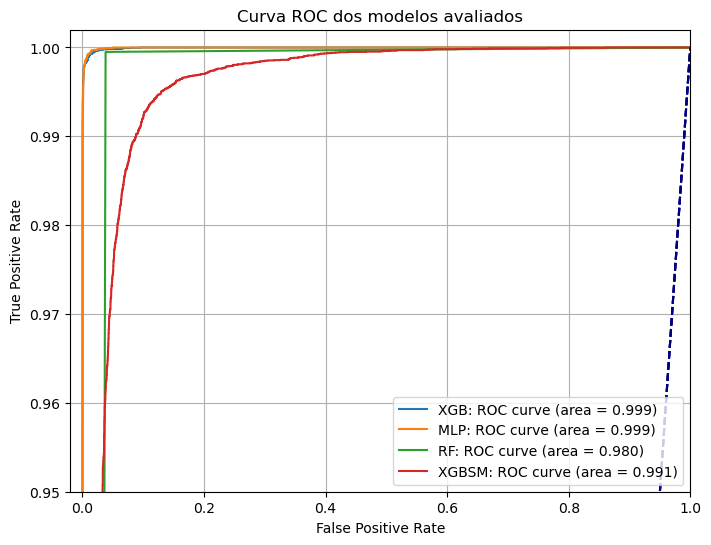

In [78]:
plt.figure(figsize=(8, 6))
plot_roc_curve(y_true=y_train, y_scores=y_train_hat_xgb, model="XGB")


plot_roc_curve(y_true=y_train, y_scores=y_train_hat_mlp, model="MLP")


plot_roc_curve(y_true=y_train, y_scores=y_train_hat_rf, model="RF")


plot_roc_curve(y_true=y_train, y_scores=y_train_hat_xgb_wm, model="XGBSM")
plt.grid()



plt.xlabel("False Positive Rate")


plt.ylabel("True Positive Rate")


plt.title("Curva ROC dos modelos avaliados")


plt.legend(loc="lower right")


plt.show()

In [79]:
from functions import models_metrics_markdown

In [80]:
metrics_data = {
    "XGB": {"ROC": roc_xgb, "KS": ks_xgb, "CVM": cvm_xgb},
    "MLP": {"ROC": roc_mlp, "KS": ks_mlp, "CVM": cvm_mlp},
    "RF": {"ROC": roc_rf, "KS": ks_rf, "CVM": cvm_rf},
    "XGBSM": {"ROC": roc_xgb_wm, "KS": ks_xgb_wm, "CVM": cvm_xgb_wm},
}

In [81]:
models_metrics_markdown(metrics_data)

| Model | ROC | KS | CVM |
|---|---|---|---| 
| XGB | 0.99995 | 0.03581 | 0.07217 |
| MLP | **0.99997** | 0.46436 | 0.11134 |
| RF | 0.98071 | **0.02855** | 0.12376 |
| XGBSM | 0.99158 | 0.03436 | **0.00100** |


Embora a MLP não apresente valores de KS e CVM tão interessantes, destaca-se pelo alto ROC. Além disso, utiliza uma lógica diferente dos algoritmos de árvore aplicados. Dessa forma, torna-se válido aplicar um ensemble para poder extrair o melhor de cada modelo.


### Ensemble


Visando um modelo final robusto e tolerante à ausência de informações, aplicamos o ensemble. O resultado deve ser preciso, ou seja, alto ROC, mas sem negligenciar os critérios de CVM e KS, necessários para passar pelo teste final.


In [82]:
weight_xgb = 0.05
weight_mlp = 0.005
weight_rf = 0.02
weight_xgb_sm = 0.925

\begin{aligned}
\text{Previsão Final}
&= (0.05 \times \text{XGB}) + (0.005 \times \text{MLP})

- (0.02 \times \text{RF}) + (0.925 \times \text{XGBSM})
  \end{aligned}


Embora esses pesos tenham sido definidos empiricamente para alcançar valores adequados de KS e CVM, poderíamos ter explorado alternativas como a regressão linear ou até mesmo uma rede neural, ambas com o objetivo de minimizar KS e CVM e, assim, determinar pesos mais precisos.


In [83]:
weights_corr = np.array([weight_xgb, weight_mlp, weight_rf, weight_xgb_sm]).reshape(
    -1, 1
)
sum(weights_corr)

array([1.])

In [84]:
y_trains = np.array(
    [y_train_hat_xgb, y_train_hat_mlp, y_train_hat_rf, y_train_hat_xgb_wm]
)


y_agres = np.array([y_agre_hat_xgb, y_agre_hat_mlp, y_agre_hat_rf, y_agre_hat_xgb_wm])
y_corrs = np.array([y_corr_hat_xgb, y_corr_hat_mlp, y_corr_hat_rf, y_corr_hat_xgb_wm])

In [85]:
def calc_ensemble(models, weights):
    return sum(models * weights) / weights.sum()

In [86]:
train_result = calc_ensemble(models=y_trains, weights=weights_corr)
agre_result = calc_ensemble(models=y_agres, weights=weights_corr)
corr_result = calc_ensemble(models=y_corrs, weights=weights_corr)

## Evaluation


In [87]:
final_roc = roc_auc_score(y_true=y_train, y_score=train_result)
final_ks = check_ks(agreement_probs=agre_result, check_agreement=check_agreement)
final_cvm = compute_cvm(predictions=corr_result, masses=check_correlation["mass"])

In [88]:
metrics_markdown(final_roc, final_ks, final_cvm)


| Metric | Value | Status |
|---|---|---|
| ROC | 0.99627 |   |
| KS  | 0.03709 | ✅ |
| CVM | 0.0018145 | ✅ |


Podemos observar que nosso modelo final está um ROC alto, passa no teste do KS e também do CVM.


## Submission


Todas as etapas anteriores de avaliação de KS e CVM tiveram como objetivo aprimorar os pesos do ensemble e a escolha dos modelos para aplicação nos dados de teste. Alcançamos resultados consistentes, dentro dos critérios de ROC, agreement e correlation, o que nos permite aplicar o modelo ao conjunto de teste e submetê-lo ao Kaggle.


In [89]:
y_test_hat_mlp = np.ravel((nn_model.predict(X_test_scaled)))
y_test_hat_rf = rf_model.predict(X_test)
y_test_hat_xgb = xgb_model.predict(xgb.DMatrix(X_test, feature_names=feature_names))
y_test_hat_xgb_wm = xgb_model_wm.predict(
    xgb.DMatrix(X_test_wm, feature_names=feature_names_sm)
)

26745/26745 ━━━━━━━━━━━━━━━━━━━━ 19s 708us/step


In [90]:
y_tests = np.array([y_test_hat_xgb, y_test_hat_mlp, y_test_hat_rf, y_test_hat_xgb_wm])

In [91]:
test_result = calc_ensemble(models=y_tests, weights=weights_corr)

In [92]:
test = pd.read_csv("data/test.csv", index_col="id")
result = pd.DataFrame({"id": test.index})
result["prediction"] = test_result

In [93]:
result.head()

,id,prediction
0,14711831,0.627952
1,16316387,0.596896
2,6771382,0.821954
3,686045,0.543113
4,8755882,0.593933


In [94]:
result.to_csv("result.csv", index=False, sep=",")

In [95]:
sub_ex = pd.read_csv("data/sample_submission.csv")

Text(0.5, 1.0, 'Histograma das predições')

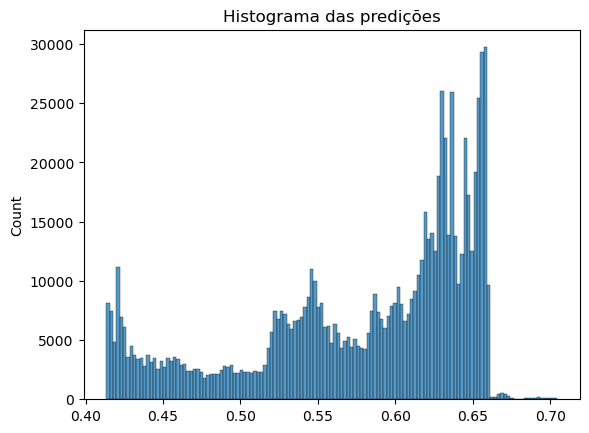

In [96]:
sns.histplot(sub_ex["prediction"].values)
plt.title("Histograma das predições")

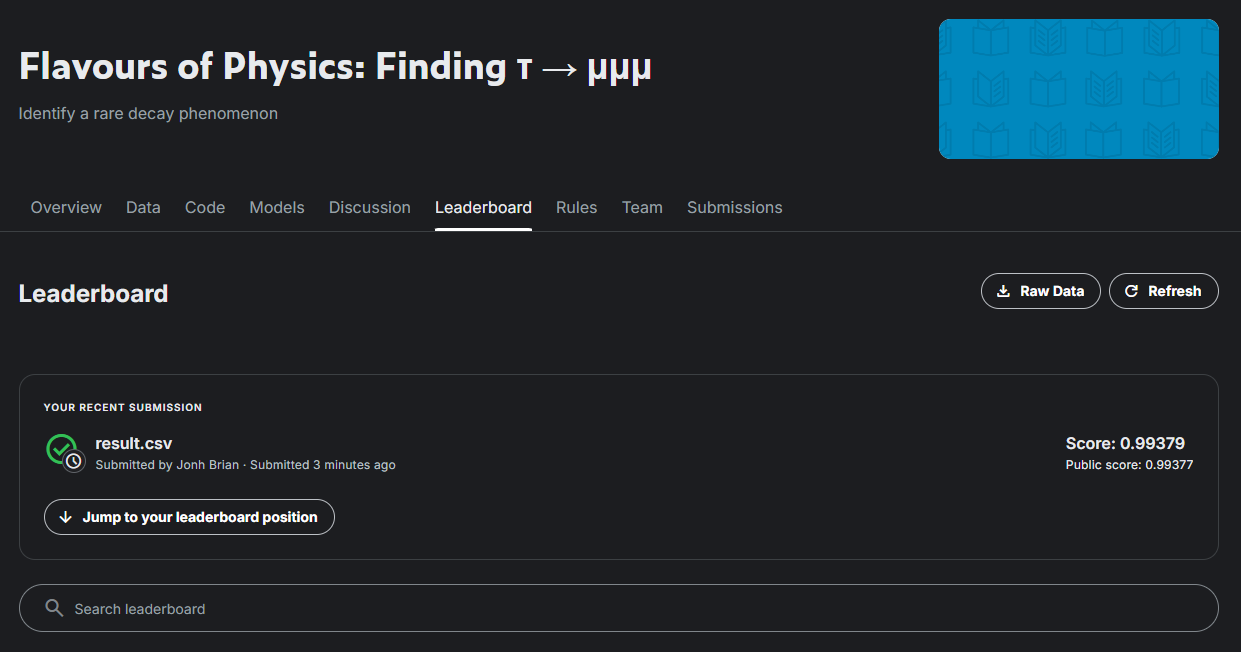


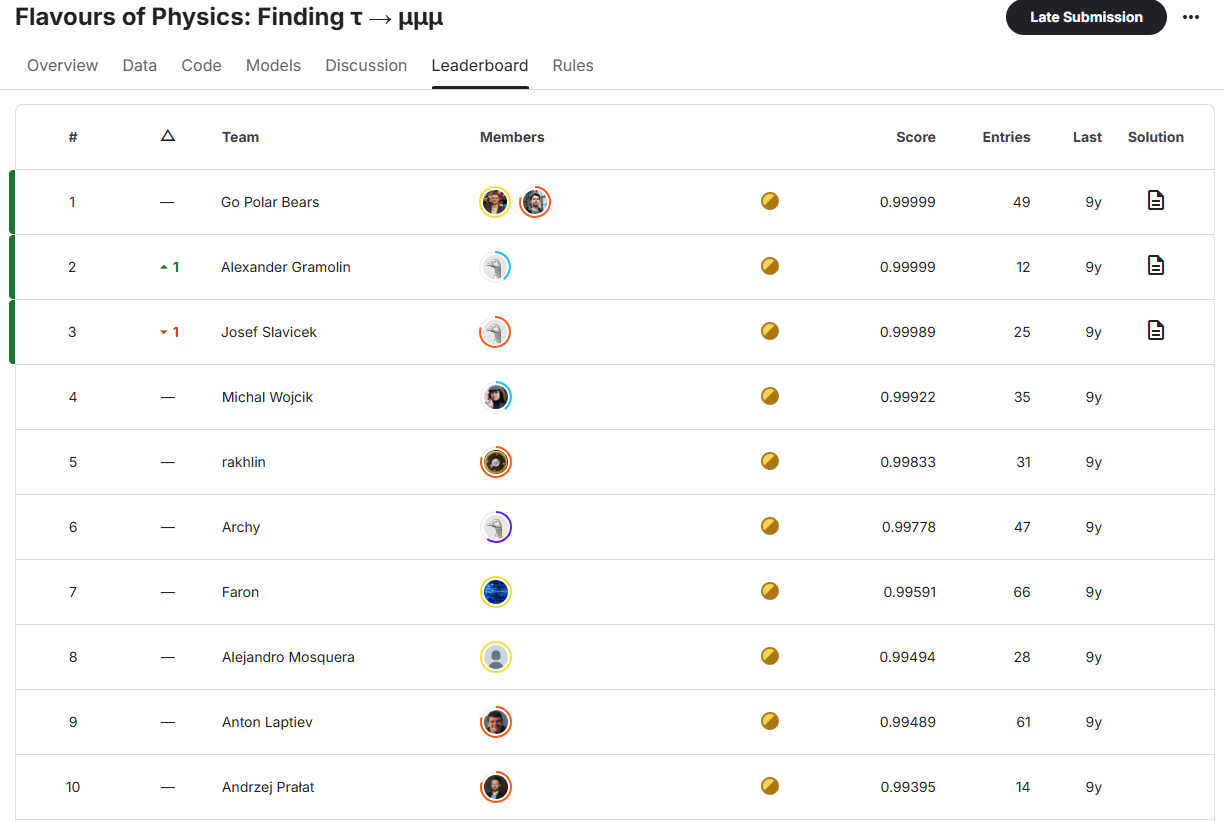


Observando o leaderboard, verificamos estaríamos décima primeira colocação, o que demonstra a eficiência do modelo desenvolvido.
